### We managed to get the data to run. Let's see if the pipeline works

#### Get Dev Data

In [1]:
import sys, os, json
sys.path.insert(1, "../../")
from src.combine import combine_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

### Modify the information below for every monitoring attempt

In [2]:
with open("../../config.json", "r") as f:
    config = json.load(f)
    
mconfig = config["monitoring_config"]
locals().update(mconfig)   # this would set k-v pairs in mconfig as local variables
print(mconfig.keys())

dict_keys(['mmonth', 'dev_df_path', 'monitoring_dates', 'prod_data_dates', 'data_output_path', 'artifact_path', 'date_sample_start', 'date_sample_end', 'model_paths', 'prev_test_df_path'])


In [3]:
static_sample_dates = [pd.to_datetime(d) for d in monitoring_dates]
date_sample_end = pd.to_datetime(date_sample_end)

In [4]:
# may need to modify the method which to load data
df = pd.read_feather(dev_df_path)
prev_test_df = pd.read_parquet(prev_test_df_path)

### Read and process Dev data

In [5]:
# split to train test set
modeling_df = df[df.sample_date <= date_sample_end]

test_df = df[df.is_static 
             & (df.sample_date.isin(monitoring_dates))]

# get the last snapshot of the last development cycle.
# e.g. create a static sample on the last day. 
first_static_date = prev_test_df[prev_test_df.is_static].sample_date.min()
prev_test_df = prev_test_df[prev_test_df.is_static &
                            (prev_test_df.sample_date == first_static_date)]


#### usually the first monitoring date is equal to the day after the last day of the development data. We will benchmark PSI based on that date.

Text(0.5, 1.0, 'prev first monitoring date')

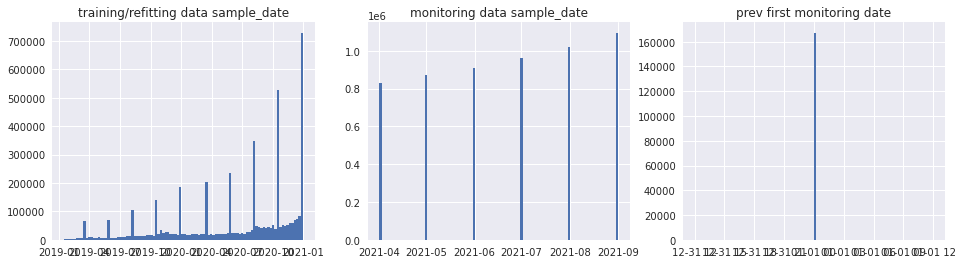

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
modeling_df.sample_date.hist(bins=100, ax=axs[0])
test_df.sample_date.hist(bins=100, ax=axs[1])
prev_test_df.sample_date.hist(bins=100, ax=axs[2])

axs[0].set_title("training/refitting data sample_date")
axs[1].set_title("monitoring data sample_date") 
axs[2].set_title("prev first monitoring date")  

In [7]:
modeling_df.shape, test_df.shape, test_df.sample_date.unique(), prev_test_df.shape

((4678757, 91),
 (5688272, 91),
 array(['2021-04-01T00:00:00.000000000', '2021-05-01T00:00:00.000000000',
        '2021-06-01T00:00:00.000000000', '2021-07-01T00:00:00.000000000',
        '2021-08-01T00:00:00.000000000', '2021-09-01T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 (167293, 91))

In [8]:
train_dt_str = modeling_df.sample_date.max().strftime('%Y-%m-%d')
mdf_path = os.path.join(data_output_path, f"modeling_df_{train_dt_str}.parquet")
modeling_df.to_parquet(mdf_path)

tdf_path = os.path.join(data_output_path, f"test_df_{mmonth}.parquet")
test_df.to_parquet(tdf_path)

prev_tdf_path = os.path.join(data_output_path, "prev_test_df.parquet")
prev_test_df.to_parquet(prev_tdf_path)

In [9]:
mconfig["modeling_df_path"] = mdf_path
mconfig["test_df_path"] = tdf_path
mconfig["prev_test_df_path"] = prev_tdf_path

#### Get Prod Data

In [10]:
!pip install --index-url https://build.sofi.com/artifactory/api/pypi/pypi/simple sofiproto==release-1703
!pip install read_protobuf

Looking in indexes: https://build.sofi.com/artifactory/api/pypi/pypi/simple


In [11]:
sys.path.insert(1, "../..")
from src.monitoring.download_customer_prod import download_customer_prod_data

print(mmonth)

2021-09


In [12]:
%%time 

prod_dfs_path = {}

for last_monitoring_date in prod_data_dates:
    print(last_monitoring_date)
    output_path = f"s3://sofi-data-science/jxu/monitoring/customer-risk-v1/{mmonth}/prod-data-{last_monitoring_date}.parquet"
    download_customer_prod_data(output_path)
    
    prod_dfs_path[last_monitoring_date] = output_path
    

2021-09-30
querying money user data...
some data processing...
CPU times: user 2min 19s, sys: 36.6 s, total: 2min 56s
Wall time: 16min 56s


In [13]:
mconfig["prod_dfs_path"] = prod_dfs_path

In [14]:
config["monitoring_config"] = mconfig

with open("../../config.json", "w") as f:
    json.dump(config, f, indent=4)